# Description:

* dev dataset
* just using 10 random bacteria genomes
* dataset copied from wPDF_py
* re-coding how diffusion is modeled
  * modeling diffusion as a function of fragment length, but altering how it is implemented for speed

## Workflow:

* Fragment GC distributions
* Community abundance and incorporation
  * Simulate communities for each gradient fraction
* Simulate isotope incorp
* Creating OTU tables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome10/'
SIPSimExe = '/home/nick/notebook/SIPSim/SIPSim'

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess

In [3]:
%load_ext rpy2.ipython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Indexing genomes

* needed for *in silico* PCR to simulate amplicon-fragments

In [8]:
! cd $workDir; \
    $SIPSimExe indexGenomes genomes/genomes10.txt \
    --fp ./genomes/ --np 10 > index_log.txt

Indexing: "Roseobacter_litoralis_Och_149"
Indexing: "Idiomarina_loihiensis_GSL_199"
Indexing: "Bacillus_cereus_F837_76"
Indexing: "Micrococcus_luteus_NCTC_2665"
Indexing: "Geobacter_lovleyi_SZ"
Indexing: "Cyanobium_gracile_PCC_6307"
Indexing: "Leuconostoc_citreum_KM20"
Indexing: "Escherichia_coli_APEC_O78"
Indexing: "Xanthomonas_axonopodis_Xac29-1"
Indexing: "Nitrosomonas_europaea_ATCC_19718"


### Simulating fragments and calculating G+C

In [285]:
%%bash -s "$workDir" "$SIPSimExe"
# amplicon fragments

cd $1

$2 fragGC genomes/genomes10.txt \
    --fp ./genomes/ --fr 515Fm-927Rm.fna \
    --np 10 > genome10_ampFragGC.txt

Processing: "Roseobacter_litoralis_Och_149"
Processing: "Idiomarina_loihiensis_GSL_199"
Processing: "Bacillus_cereus_F837_76"
Processing: "Micrococcus_luteus_NCTC_2665"
Processing: "Geobacter_lovleyi_SZ"
Processing: "Cyanobium_gracile_PCC_6307"
Processing: "Leuconostoc_citreum_KM20"
Processing: "Escherichia_coli_APEC_O78"
Processing: "Xanthomonas_axonopodis_Xac29-1"
Processing: "Nitrosomonas_europaea_ATCC_19718"


In [286]:
%%bash -s "$workDir" "$SIPSimExe"
# shotgun fragments

cd $1

$2 fragGC genomes/genomes10.txt \
    --fp ./genomes/ --np 10 \
    > genome10_shotFragGC.txt

Processing: "Roseobacter_litoralis_Och_149"
Processing: "Idiomarina_loihiensis_GSL_199"
Processing: "Bacillus_cereus_F837_76"
Processing: "Micrococcus_luteus_NCTC_2665"
Processing: "Geobacter_lovleyi_SZ"
Processing: "Cyanobium_gracile_PCC_6307"
Processing: "Leuconostoc_citreum_KM20"
Processing: "Escherichia_coli_APEC_O78"
Processing: "Xanthomonas_axonopodis_Xac29-1"
Processing: "Nitrosomonas_europaea_ATCC_19718"


### Simulating gradient communities

In [287]:
%%bash -s "$workDir" "$SIPSimExe"

cd $1

$2 gradientComms genomes/genomes10.txt \
    --fp ./genomes/  --pf grinder_profile \
    > genome10_comm_n3.txt

Overall diversity = 10 genomes
Percent shared   = 100.0 % (10 genomes)
Percent permuted = 100.0 % (10 top genomes)


### Simulating isotope incorporation

In [288]:
import os

# making config file
config = """
[library 1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform
  weight = 1

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

[library 2]
  # split intra-populations
  ## to get some taxa with split; use inter-pop mixture for 2nd intra-pop mu, where mixture is highly uneven
  
  [[intraPopDist 1]]
  distribution = normal
  weight = 0.5

    [[[mu]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 90
        sigma = 2

    [[[sigma]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 5
        sigma = 2

  [[intraPopDist 2]]
  distribution = normal
  weight = 0.5

    [[[mu]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 5
        sigma = 2

    [[[sigma]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 5
        sigma = 2


[library 3]
  # split inter-pop distribution (some approx. full; others none)
  
  [[intraPopDist 1]]
  distribution = normal
  weight = 1

    [[[mu]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 90
        sigma = 2

      # these taxa in the community get no incorp
      [[[[interPopDist 2]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[sigma]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 5
        sigma = 2
        

"""

outfile = os.path.join(workDir, 'genome10_n3.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [289]:
import os

# making config file
config = """
[library 1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform
  weight = 1

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

[library 2]
  # full incorp
  
  [[intraPopDist 1]]
  distribution = uniform
  weight = 1

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 100
        end = 100

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 100
        end = 100

[library 3]
  # split inter-pop distribution (some approx. full; others none)
  
  [[intraPopDist 1]]
  distribution = normal
  weight = 1

    [[[mu]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 90
        sigma = 2

      # these taxa in the community get no incorp
      [[[[interPopDist 2]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[sigma]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 5
        sigma = 2
        

"""

outfile = os.path.join(workDir, 'genome10_n3.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [290]:
%%bash -s "$workDir" "$SIPSimExe"

cd $1

$2 isoIncorp genome10_comm_n3.txt genome10_n3.config > genome10_comm_n3_incorp.txt

#### Plotting incorporation in R

In [291]:
%%R
library(ggplot2)
library(dplyr)

In [292]:
%%R -i workDir

infile = paste(c(workDir, 'genome10_comm_n3_incorp.txt'), collapse='/')

tbl = read.csv(infile, sep='\t')

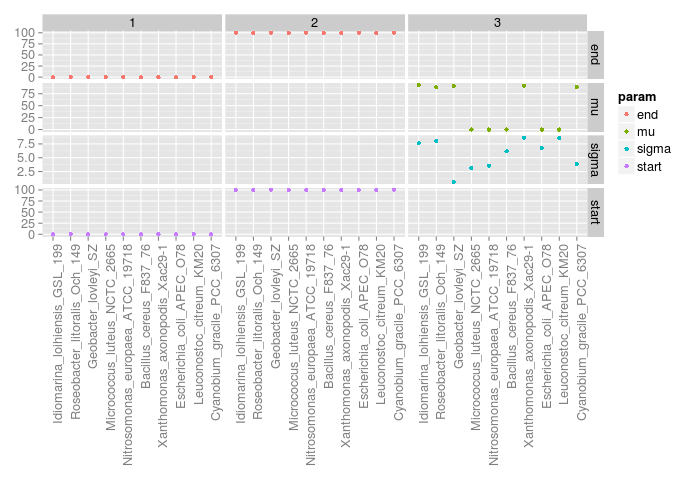

In [293]:
%%R -w 700 

tbl$taxon_name = reorder(tbl$taxon_name, tbl$param_value, max)

ggplot(tbl, aes(taxon_name, param_value, color=param)) +
    geom_point() +
    facet_grid(param ~ library, scales='free_y') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, hjust=1),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()
    )

### Simulating gradient fractions

In [294]:
%%bash -s "$workDir" "$SIPSimExe"

cd $1

$2 fractions genome10_comm_n3.txt > genome10_comm_n3_fracs.txt

In [295]:
%%R -i workDir

infile = paste(c(workDir, 'genome10_comm_n3_fracs.txt'), collapse='/')

tbl = read.csv(infile, sep='\t')

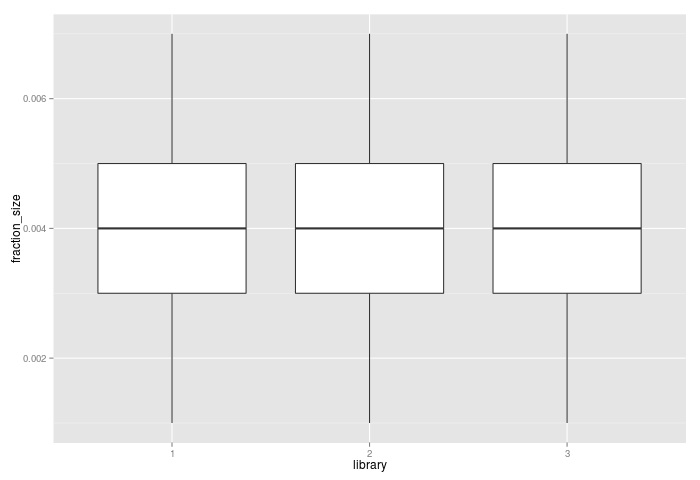

In [296]:
%%R -w 700 

#tbl$taxon_name = reorder(tbl$taxon_name, tbl$param_value, max)
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot()

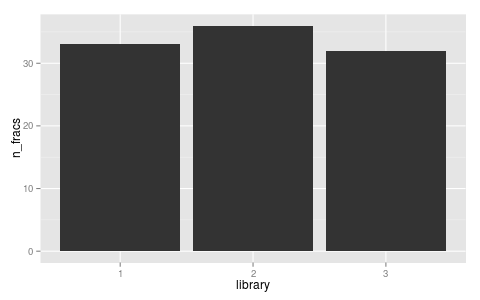

In [297]:
%%R -h 300
tbl_sum = group_by(tbl, library) %>%
    summarize( n_fracs = n())

ggplot(tbl_sum, aes(library, n_fracs)) +
    geom_bar(stat='identity')

### Creating OTU table & plotting simulated fragment info

In [298]:
%%bash -s "$workDir" "$SIPSimExe"

cd $1

$2 OTU_table genome10_ampFragGC.txt genome10_comm_n3.txt \
    genome10_comm_n3_incorp.txt genome10_comm_n3_fracs.txt \
    --abs_abund 1e4 --log genome10_OTU_abnd1e4_log.txt \
    > genome10_OTU_abnd1e4.txt

Processing library: "1"
  Processing taxon: "Bacillus_cereus_F837_76"
    N-fragments:   1130
    Time elapsed:  0.0 sec
  Processing taxon: "Roseobacter_litoralis_Och_149"
    N-fragments:   1098
    Time elapsed:  0.0 sec
  Processing taxon: "Xanthomonas_axonopodis_Xac29-1"
    N-fragments:   1068
    Time elapsed:  0.0 sec
  Processing taxon: "Escherichia_coli_APEC_O78"
    N-fragments:   1039
    Time elapsed:  0.0 sec
  Processing taxon: "Leuconostoc_citreum_KM20"
    N-fragments:   1010
    Time elapsed:  0.0 sec
  Processing taxon: "Cyanobium_gracile_PCC_6307"
    N-fragments:   983
    Time elapsed:  0.0 sec
  Processing taxon: "Geobacter_lovleyi_SZ"
    N-fragments:   955
    Time elapsed:  0.0 sec
  Processing taxon: "Nitrosomonas_europaea_ATCC_19718"
    N-fragments:   929
    Time elapsed:  0.0 sec
  Processing taxon: "Micrococcus_luteus_NCTC_2665"
    N-fragments:   904
    Time elapsed:  0.0 sec
  Processing taxon: "Idiomarina_loihiensis_GSL_199"
    N-fragments:   879
  

#### Plotting out fragment info

In [299]:
%%R -i workDir

# loading file
infile = paste(c(workDir, 'genome10_OTU_abnd1e4_log.txt'), collapse='/')
tbl = read.csv(infile, sep='\t')

# reformat
tbl$taxon = gsub("(.*?_.*?)_(.+)", "\\1\n\\2", tbl$taxon)
tbl$fragment_length = tbl$fragment_length / 1000

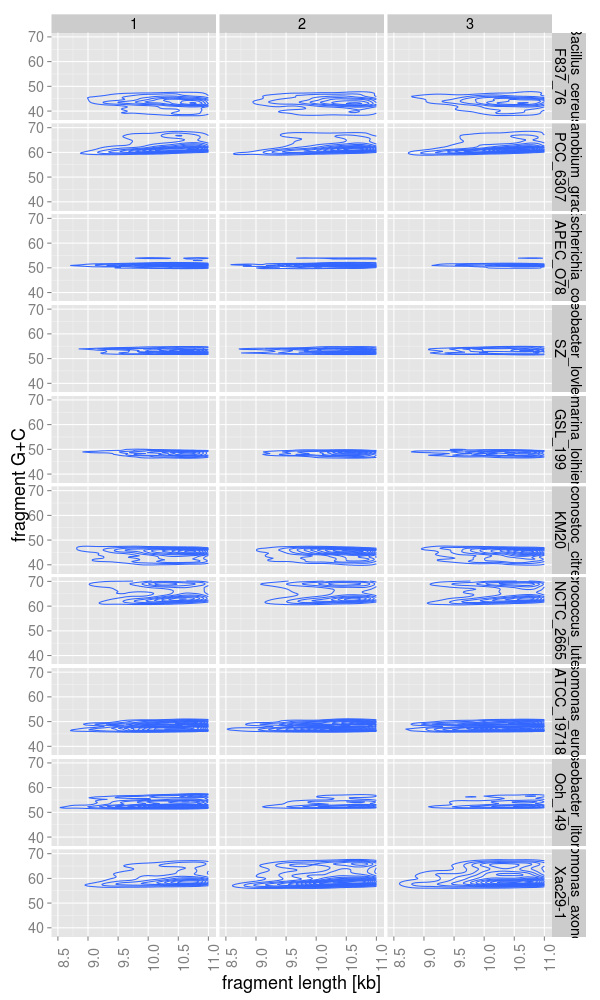

In [300]:
%%R -w 600 -h 1000
# plot

ggplot(tbl, aes(fragment_length, fragment_GC)) +
    geom_density2d() +
    facet_grid(taxon ~ library) +
    labs(x="fragment length [kb]", y="fragment G+C") +
    theme(
        text = element_text(size=18),
        axis.text.x = element_text(angle=90)
    )

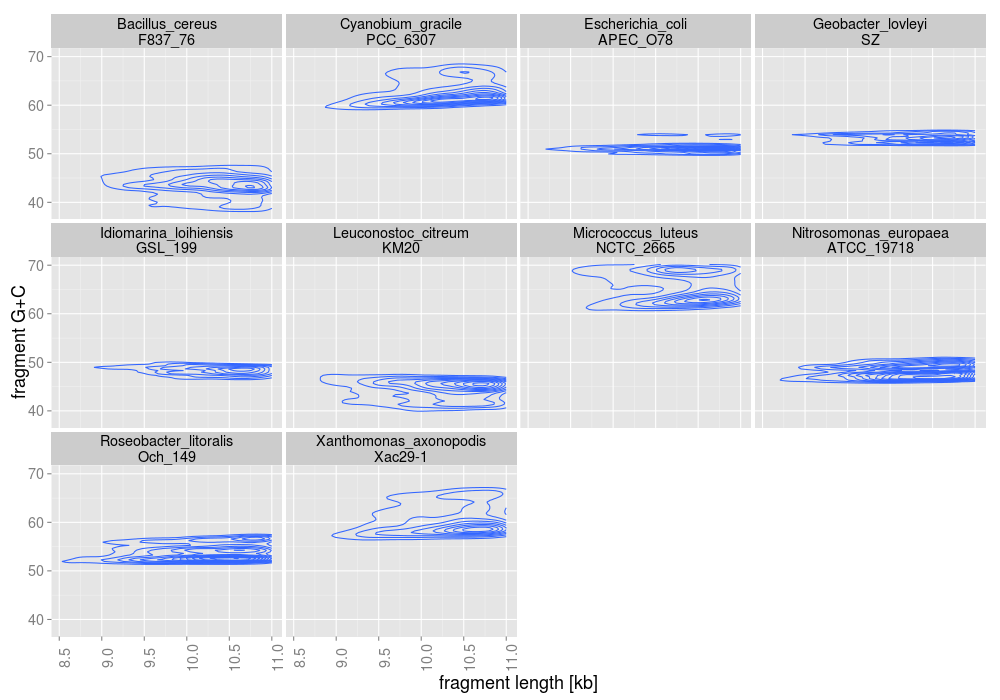

In [301]:
%%R -w 1000 -h 700
# plot

tbl.l1 = tbl %>% filter(library == 1)

ggplot(tbl.l1, aes(fragment_length, fragment_GC)) +
    geom_density2d() +
    facet_wrap( ~ taxon) +
    labs(x="fragment length [kb]", y="fragment G+C") +
    theme(
        text = element_text(size=18),
        axis.text.x = element_text(angle=90)
    )

### Creating community of larger total abundance

In [302]:
%%bash -s "$workDir" "$SIPSimExe"

cd $1

$2 OTU_table genome10_shotFragGC.txt genome10_comm_n3.txt \
    genome10_comm_n3_incorp.txt genome10_comm_n3_fracs.txt \
    --abs_abund 1e5 > genome10_OTU_abnd1e6.txt

Processing library: "1"
  Processing taxon: "Bacillus_cereus_F837_76"
    N-fragments:   11300
    Time elapsed:  0.2 sec
  Processing taxon: "Roseobacter_litoralis_Och_149"
    N-fragments:   10989
    Time elapsed:  0.1 sec
  Processing taxon: "Xanthomonas_axonopodis_Xac29-1"
    N-fragments:   10687
    Time elapsed:  0.1 sec
  Processing taxon: "Escherichia_coli_APEC_O78"
    N-fragments:   10393
    Time elapsed:  0.1 sec
  Processing taxon: "Leuconostoc_citreum_KM20"
    N-fragments:   10107
    Time elapsed:  0.1 sec
  Processing taxon: "Cyanobium_gracile_PCC_6307"
    N-fragments:   9830
    Time elapsed:  0.1 sec
  Processing taxon: "Geobacter_lovleyi_SZ"
    N-fragments:   9559
    Time elapsed:  0.1 sec
  Processing taxon: "Nitrosomonas_europaea_ATCC_19718"
    N-fragments:   9296
    Time elapsed:  0.1 sec
  Processing taxon: "Micrococcus_luteus_NCTC_2665"
    N-fragments:   9041
    Time elapsed:  0.1 sec
  Processing taxon: "Idiomarina_loihiensis_GSL_199"
    N-fragments:

### Plotting out values

In [5]:
%%R -i workDir

# loading file
infile = paste(c(workDir, 'genome10_OTU_abnd1e6.txt'), collapse='/')
tbl = read.csv(infile, sep='\t')

In [6]:
%%R

# formatting table
tbl$BD_min = gsub('-.+', '', tbl$fractions)
tbl$BD_min = as.numeric(tbl$BD_min)
tbl$BD_max = gsub('.+-', '', tbl$fractions)
tbl$BD_max = as.numeric(tbl$BD_max)

In [7]:
%%R

# summarizing counts (should be approx. total abundance)
tbl %>%
    group_by(library) %>%
    summarize(sum(count))

Source: local data frame [3 x 2]

  library sum(count)
1       1     999995
2       2     999995
3       3     999994


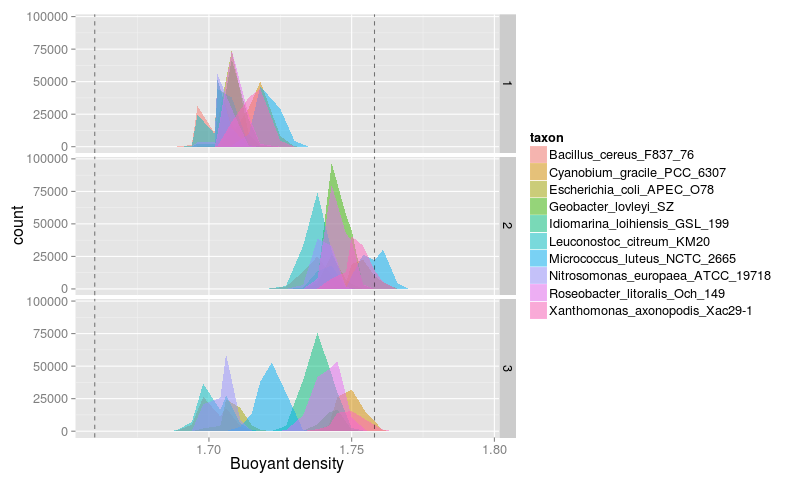

In [8]:
%%R -w 800
# plotting absolute abundances

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

## plot
ggplot(tbl, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    facet_grid(library ~ .) +
    labs(x='Buoyant density') +
    theme( text = element_text(size=16) )

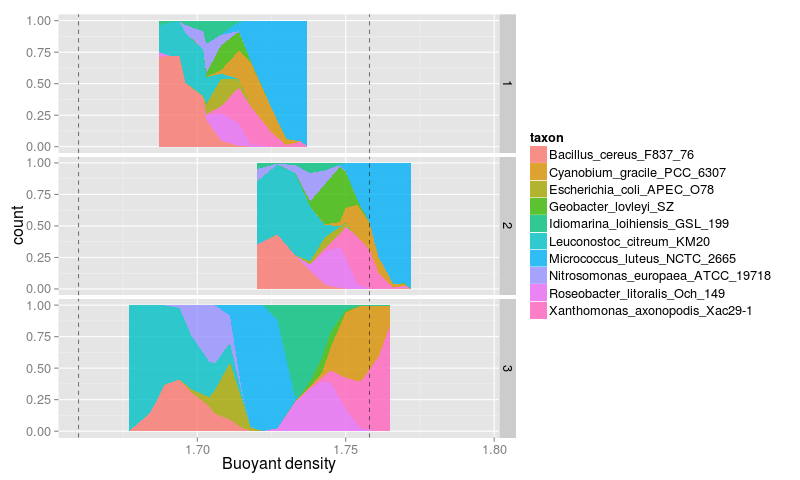

In [9]:
%%R -w 800

# plotting relative abundances
ggplot(tbl, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.8, position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    facet_grid(library ~ .) +
    labs(x='Buoyant density') +
    theme( text = element_text(size=16) )

__Notes:__

* Limited 'noise'; taxa not present in (nearly) all fractions as seen empirically
  * This could be caused by:
    * Too low of total abundance?
    * Smaller fragments present, which have high diffusion
  

***
### Example plot

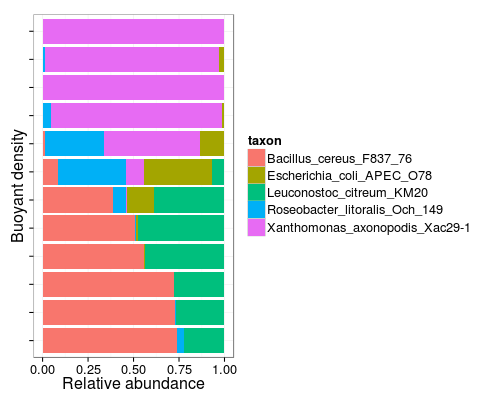

In [48]:
%%R -w 500 -h 400

taxa.sel = unique(tbl$taxon)[1:5]
tbl.tmp = filter(tbl, library == 1, taxon %in% taxa.sel, count > 0)

x = as.character(tbl.tmp$BD_min)
tbl.tmp$BD_min = factor(x, levels=x[order(tbl.tmp$BD_min)])

# plotting relative abundances
ggplot(tbl.tmp, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_bar(stat='identity', position='fill') +
    labs(x='Buoyant density', y='Relative abundance') +
    coord_flip() +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.text.y = element_blank()
    )

***

## Simulating community with some smaller fragments (no min. size limit)

In [359]:
!cd $workDir; \
    $SIPSimExe fragGC genomes/genomes10.txt \
    --fp ./genomes/ \
    --fr 515Fm-927Rm.fna \
    --fld skewed-normal,9000,2500,-5  \
    --flr 500,None \
    --np 10 \
    > genome10_ampFragGC_difSkew.txt

Processing: "Roseobacter_litoralis_Och_149"
Processing: "Idiomarina_loihiensis_GSL_199"
Processing: "Bacillus_cereus_F837_76"
Processing: "Micrococcus_luteus_NCTC_2665"
Processing: "Geobacter_lovleyi_SZ"
Processing: "Cyanobium_gracile_PCC_6307"
Processing: "Leuconostoc_citreum_KM20"
Processing: "Escherichia_coli_APEC_O78"
Processing: "Xanthomonas_axonopodis_Xac29-1"
Processing: "Nitrosomonas_europaea_ATCC_19718"


#### Plotting fragment sizes

In [360]:
%%R -i workDir

setwd(workDir)
infile = 'genome10_ampFragGC_difSkew.txt'

tbl = read.delim(infile, sep='\t')

tbl$frag_len = abs(tbl$fragEnd - tbl$fragStart) + 1

[1] 0.04442


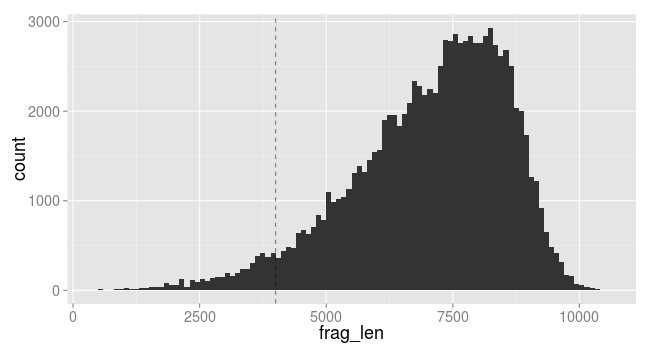

In [361]:
%%R -h 350 -w 650

# stats
print(length(tbl[tbl$frag_len < 4000, 'frag_len']) / nrow(tbl))

# plot
ggplot(tbl, aes(frag_len)) +
    geom_histogram(binwidth=100) +
    geom_vline(xintercept=4000, linetype='dashed', alpha=0.5) +
    theme(
        text = element_text(size=18)
    )

#### Simulating community

In [336]:
%%bash -s "$workDir" "$SIPSimExe"

cd $1

$2 OTU_table genome10_ampFragGC_difSkew.txt genome10_comm_n3.txt \
    genome10_comm_n3_incorp.txt genome10_comm_n3_fracs.txt \
    --abs_abund 1e8 > genome10_OTU_abnd1e8.txt

Processing library: "1"
  Processing taxon: "Bacillus_cereus_F837_76"
    N-fragments:   11300354
    Time elapsed:  150.0 sec
  Processing taxon: "Roseobacter_litoralis_Och_149"
    N-fragments:   10989669
    Time elapsed:  144.4 sec
  Processing taxon: "Xanthomonas_axonopodis_Xac29-1"
    N-fragments:   10687525
    Time elapsed:  141.2 sec
  Processing taxon: "Escherichia_coli_APEC_O78"
    N-fragments:   10393689
    Time elapsed:  136.2 sec
  Processing taxon: "Leuconostoc_citreum_KM20"
    N-fragments:   10107931
    Time elapsed:  131.4 sec
  Processing taxon: "Cyanobium_gracile_PCC_6307"
    N-fragments:   9830030
    Time elapsed:  128.2 sec
  Processing taxon: "Geobacter_lovleyi_SZ"
    N-fragments:   9559769
    Time elapsed:  125.2 sec
  Processing taxon: "Nitrosomonas_europaea_ATCC_19718"
    N-fragments:   9296938
    Time elapsed:  121.2 sec
  Processing taxon: "Micrococcus_luteus_NCTC_2665"
    N-fragments:   9041334
    Time elapsed:  119.6 sec
  Processing taxon: "Id

#### Plotting out distributions

In [342]:
%%R -i workDir

# loading file
infile = paste(c(workDir, 'genome10_OTU_abnd1e8.txt'), collapse='/')
tbl = read.csv(infile, sep='\t')

In [343]:
%%R

# formatting table
tbl$BD_min = gsub('-.+', '', tbl$fractions)
tbl$BD_min = as.numeric(tbl$BD_min)
tbl$BD_max = gsub('.+-', '', tbl$fractions)
tbl$BD_max = as.numeric(tbl$BD_max)

In [344]:
%%R

# summarizing counts (should be approx. total abundance)
tbl %>%
    group_by(library) %>%
    summarize(sum(count))

Source: local data frame [3 x 2]

  library sum(count)
1       1   99999996
2       2   99999995
3       3   99999994


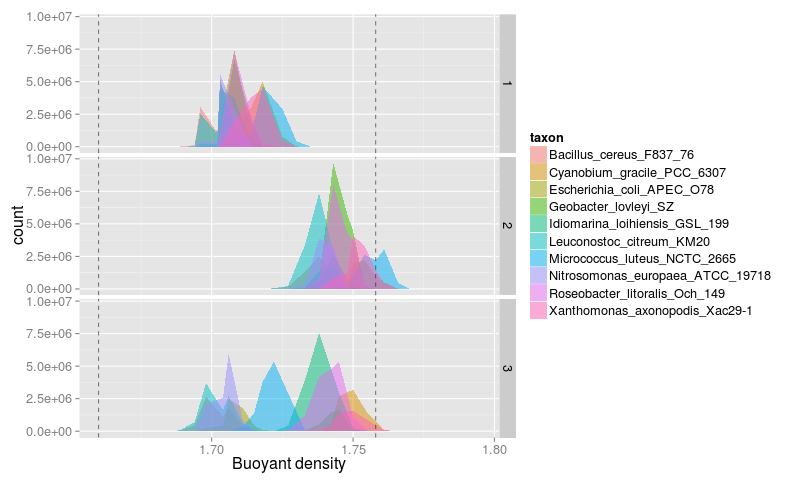

In [345]:
%%R -w 800
# plotting absolute abundances

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

## plot
ggplot(tbl, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    facet_grid(library ~ .) +
    labs(x='Buoyant density') +
    theme( text = element_text(size=16) )

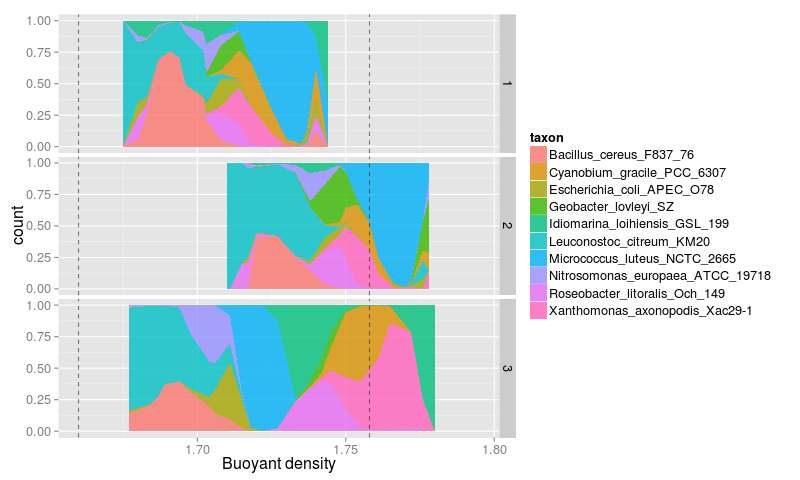

In [346]:
%%R -w 800

# plotting relative abundances
ggplot(tbl, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.8, position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    facet_grid(library ~ .) +
    labs(x='Buoyant density') +
    theme( text = element_text(size=16) )

***
***
***
***

In [367]:
%%R -i workDir

infile = paste(c(workDir, 'genome10_OTU_abnd1e6.txt'), collapse='/')

tbl = read.csv(infile, sep='\t', row.names=1)
tbl$taxon_name = rownames(tbl)

In [368]:
%%R
tbl.m = melt(tbl, id.var=c('taxon_name'))
colnames(tbl.m) = c('taxon_name', 'variable', 'abundance')

tbl.m$lib = gsub('X|\\..+', '', tbl.m$variable)
tbl.m$BD_min = gsub('X[0-9]+\\.([0-9]+\\.[0-9]+).+', '\\1', tbl.m$variable)
tbl.m$BD_min = as.numeric(tbl.m$BD_min)
tbl.m$BD_max = gsub('X[0-9]+\\.[0-9]+\\.[0-9]+\\.(.+)', '\\1', tbl.m$variable)
tbl.m$BD_max = as.numeric(tbl.m$BD_max)

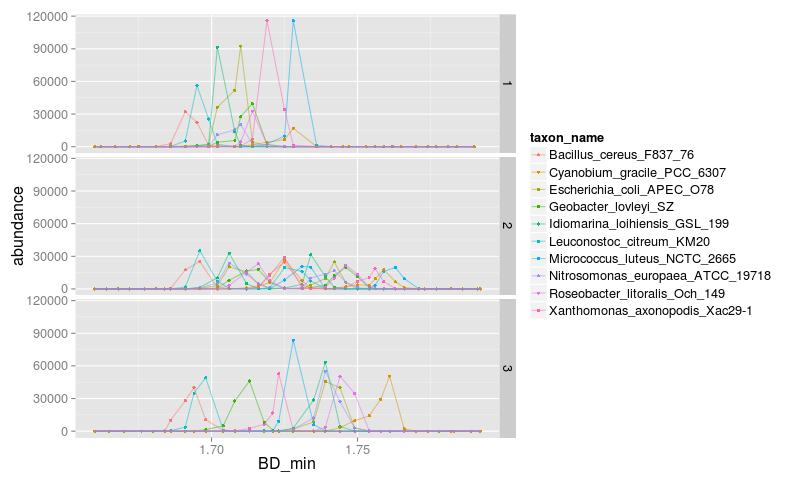

In [369]:
%%R -w 800

ggplot(tbl.m, aes(BD_min, abundance, color=taxon_name, group=taxon_name)) +
    geom_point(size=1.5) +
    geom_line(alpha=0.5) +
    facet_grid(lib ~ .) +
    theme( text = element_text(size=16) )

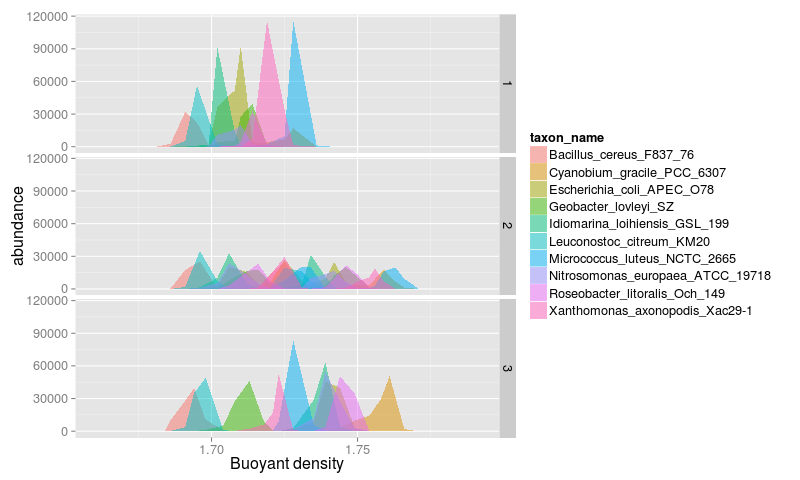

In [370]:
%%R -w 800

ggplot(tbl.m, aes(BD_min, abundance, fill=taxon_name, group=taxon_name)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    facet_grid(lib ~ .) +
    labs(x='Buoyant density') +
    theme( text = element_text(size=16) )

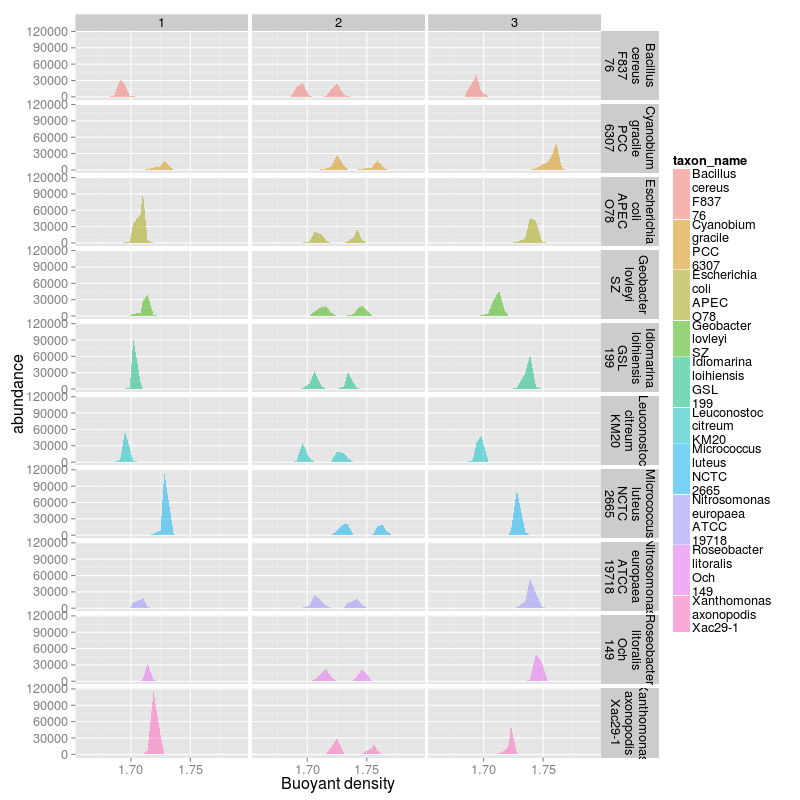

In [373]:
%%R -w 800 -h 800

tbl.m2 = tbl.m
tbl.m2$taxon_name = gsub("_","\n", tbl.m2$taxon_name)

ggplot(tbl.m2, aes(BD_min, abundance, fill=taxon_name, group=taxon_name)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    facet_grid(taxon_name ~ lib) +
    labs(x='Buoyant density') +
    theme( text = element_text(size=16) )

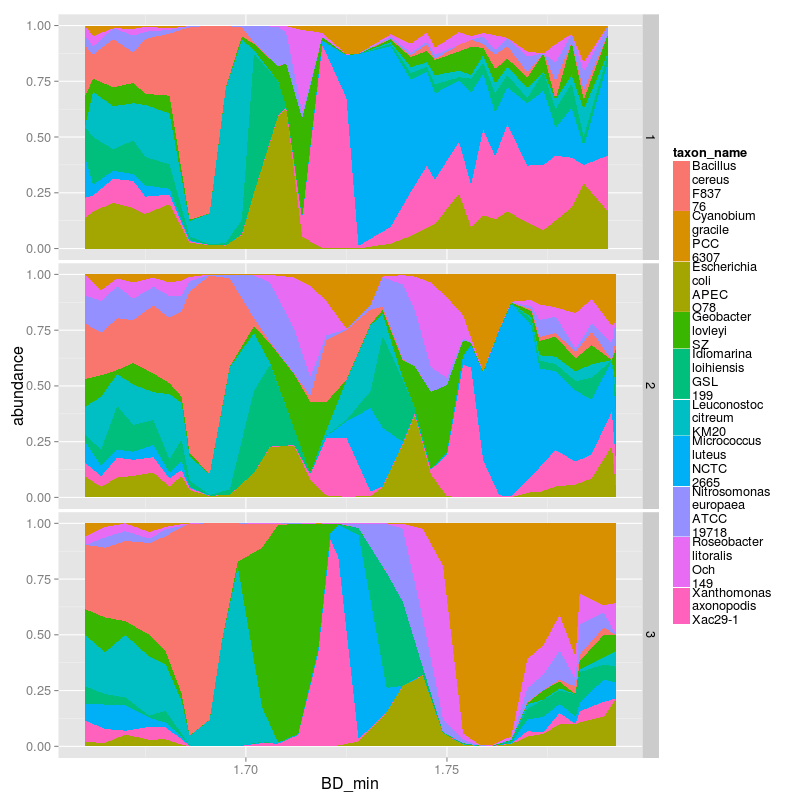

In [372]:
%%R -w 800 -h 800

tbl.m2 = tbl.m
tbl.m2$taxon_name = gsub("_","\n", tbl.m2$taxon_name)

ggplot(tbl.m2, aes(BD_min, abundance, fill=taxon_name, group=taxon_name)) +
    geom_area(stat='identity', position='fill') +
    facet_grid(lib ~ .) +
    theme( text = element_text(size=16) )

### Trying with same incorporation distributions

* Just looking at variability via 'noise' and G+C KDE distributions

In [285]:
import os

# making config file
config = """
[library 1]
  # no incorp
  
  [[intraPopDist 1]]
  distribution = uniform
  weight = 1

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

[library 2]
  # no incorp
  
  [[intraPopDist 1]]
  distribution = uniform
  weight = 1

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

[library 3]
  # no incorp
  
  [[intraPopDist 1]]
  distribution = uniform
  weight = 1

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
"""

outfile = os.path.join(workDir, 'genome10_n3_noInc.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [290]:
%%bash -s "$workDir"

cd $1

../../../SIPSim isoIncorp --percTaxa 50 genome10_comm_n3.txt genome10_n3_noInc.config \
> genome10_comm_n3_noIncorp.txt

In [304]:
%%bash -s "$workDir"
%time

cd $1

../../../SIPSim OTU_table \
genome10_shotFragGC.txt genome10_comm_n3.txt \
genome10_comm_n3_noIncorp.txt genome10_comm_n3_fracs.txt \
--abs_abund 1e6 > genome10_OTU_noInc_abnd1e6.txt

bash: line 1: fg: no job control
Processing library: "1"
  Processing taxon: "Escherichia_coli_APEC_O78"
  Processing taxon: "Xanthomonas_axonopodis_Xac29-1"
  Processing taxon: "Micrococcus_luteus_NCTC_2665"
  Processing taxon: "Idiomarina_loihiensis_GSL_199"
  Processing taxon: "Leuconostoc_citreum_KM20"
  Processing taxon: "Geobacter_lovleyi_SZ"
  Processing taxon: "Bacillus_cereus_F837_76"
  Processing taxon: "Nitrosomonas_europaea_ATCC_19718"
  Processing taxon: "Roseobacter_litoralis_Och_149"
  Processing taxon: "Cyanobium_gracile_PCC_6307"
Processing library: "2"
  Processing taxon: "Idiomarina_loihiensis_GSL_199"
  Processing taxon: "Micrococcus_luteus_NCTC_2665"
  Processing taxon: "Geobacter_lovleyi_SZ"
  Processing taxon: "Roseobacter_litoralis_Och_149"
  Processing taxon: "Nitrosomonas_europaea_ATCC_19718"
  Processing taxon: "Cyanobium_gracile_PCC_6307"
  Processing taxon: "Bacillus_cereus_F837_76"
  Processing taxon: "Escherichia_coli_APEC_O78"
  Processing taxon: "Leucon

In [347]:
%%R -i workDir

infile = paste(c(workDir, 'genome10_OTU_noInc_abnd1e6.txt'), collapse='/')

tbl = read.csv(infile, sep='\t', row.names=1)
tbl$taxon_name = rownames(tbl)

# editing table
tbl.m = melt(tbl, id.var=c('taxon_name'))
colnames(tbl.m) = c('taxon_name', 'variable', 'abundance')

tbl.m$lib = gsub('X|\\..+', '', tbl.m$variable)
tbl.m$BD_min = gsub('X[0-9]+\\.([0-9]+\\.[0-9]+).+', '\\1', tbl.m$variable)
tbl.m$BD_min = as.numeric(tbl.m$BD_min)
tbl.m$BD_max = gsub('X[0-9]+\\.[0-9]+\\.[0-9]+\\.(.+)', '\\1', tbl.m$variable)
tbl.m$BD_max = as.numeric(tbl.m$BD_max)

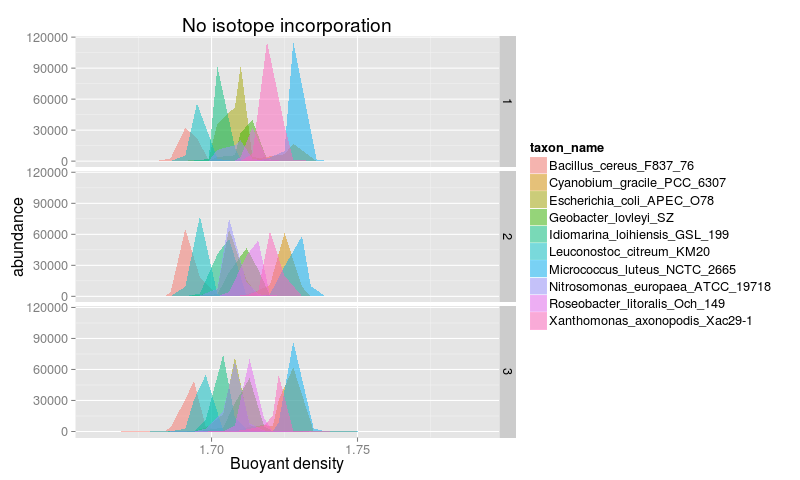

In [351]:
%%R -w 800

ggplot(tbl.m, aes(BD_min, abundance, fill=taxon_name, group=taxon_name)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    facet_grid(lib ~ .) +
    labs(title='No isotope incorporation', x='Buoyant density') +
    theme( text = element_text(size=16) )

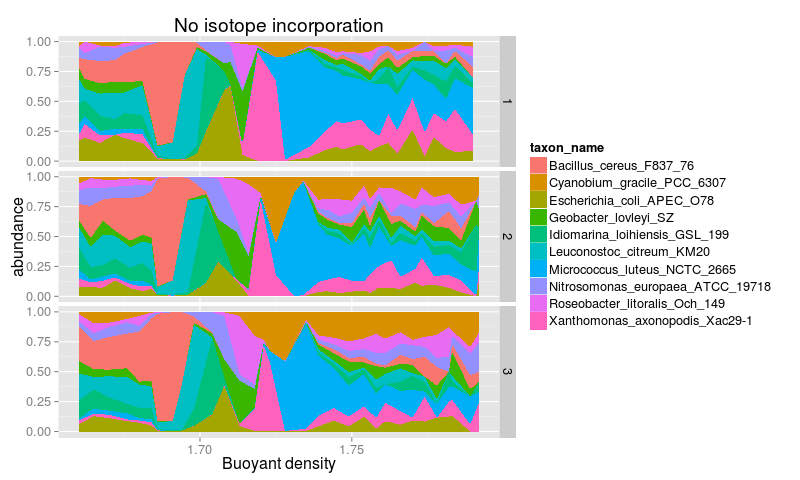

In [352]:
%%R -w 800

ggplot(tbl.m, aes(BD_min, abundance, fill=taxon_name, group=taxon_name)) +
    geom_area(stat='identity', position='fill') +
    facet_grid(lib ~ .) +
    labs(title='No isotope incorporation', x='Buoyant density') +
    theme( text = element_text(size=16) )

### Trying with same normal distributions

In [308]:
import os

# making config file
config = """
[library 1]
  # normal distribution
  
  [[intraPopDist 1]]
  distribution = normal
  weight = 1

    [[[mu]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 90
        sigma = 2

    [[[sigma]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 2
        sigma = 0.1

[library 2]
  # normal distribution
  
  [[intraPopDist 1]]
  distribution = normal
  weight = 1

    [[[mu]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 90
        sigma = 2

    [[[sigma]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 2
        sigma = 0.1

[library 3]
  # normal distribution
  
  [[intraPopDist 1]]
  distribution = normal
  weight = 1

    [[[mu]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 90
        sigma = 2

    [[[sigma]]]

      [[[[interPopDist 1]]]]
        distribution = normal
        mu = 2
        sigma = 0.1
"""

outfile = os.path.join(workDir, 'genome10_n3_norm.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [309]:
%%bash -s "$workDir"

cd $1


../../../SIPSim isoIncorp --percTaxa 100 \
genome10_comm_n3.txt genome10_n3_norm.config \
> genome10_comm_n3_normIncorp.txt

In [310]:
%%R -i workDir

infile = paste(c(workDir, 'genome10_comm_n3_normIncorp.txt'), collapse='/')

tbl = read.csv(infile, sep='\t')

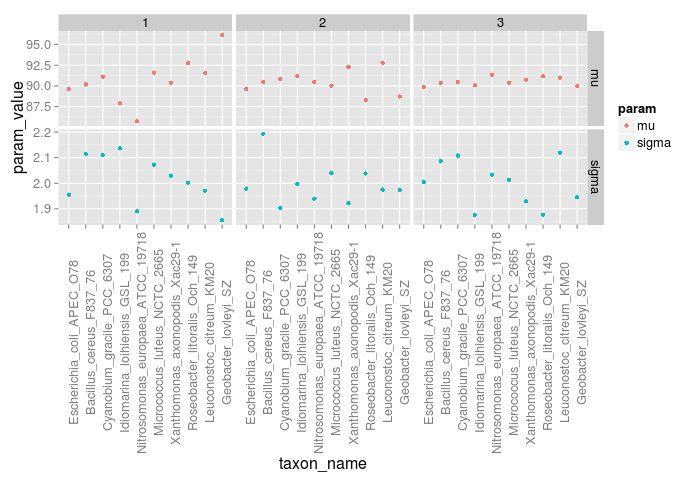

In [311]:
%%R -w 700 

tbl$taxon_name = reorder(tbl$taxon_name, tbl$param_value, max)

ggplot(tbl, aes(taxon_name, param_value, color=param)) +
    geom_point() +
    facet_grid(param ~ library, scales='free_y') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90)
    )

In [312]:
%%bash -s "$workDir"

cd $1

../../../SIPSim OTU_table \
genome10_shotFragGC.txt genome10_comm_n3.txt \
genome10_comm_n3_normIncorp.txt genome10_comm_n3_fracs.txt \
--abs_abund 1e4 > genome10_OTU_normInc_abnd1e4.txt

Processing library: "1"
  Processing taxon: "Escherichia_coli_APEC_O78"
  Processing taxon: "Xanthomonas_axonopodis_Xac29-1"
  Processing taxon: "Micrococcus_luteus_NCTC_2665"
  Processing taxon: "Idiomarina_loihiensis_GSL_199"
  Processing taxon: "Leuconostoc_citreum_KM20"
  Processing taxon: "Geobacter_lovleyi_SZ"
  Processing taxon: "Bacillus_cereus_F837_76"
  Processing taxon: "Nitrosomonas_europaea_ATCC_19718"
  Processing taxon: "Roseobacter_litoralis_Och_149"
  Processing taxon: "Cyanobium_gracile_PCC_6307"
Processing library: "2"
  Processing taxon: "Idiomarina_loihiensis_GSL_199"
  Processing taxon: "Micrococcus_luteus_NCTC_2665"
  Processing taxon: "Geobacter_lovleyi_SZ"
  Processing taxon: "Roseobacter_litoralis_Och_149"
  Processing taxon: "Nitrosomonas_europaea_ATCC_19718"
  Processing taxon: "Cyanobium_gracile_PCC_6307"
  Processing taxon: "Bacillus_cereus_F837_76"
  Processing taxon: "Escherichia_coli_APEC_O78"
  Processing taxon: "Leuconostoc_citreum_KM20"
  Processing 

In [313]:
%%R -i workDir

infile = paste(c(workDir, 'genome10_OTU_normInc_abnd1e4.txt'), collapse='/')

tbl = read.csv(infile, sep='\t', row.names=1)
tbl$taxon_name = rownames(tbl)

# editing table
tbl.m = melt(tbl, id.var=c('taxon_name'))
colnames(tbl.m) = c('taxon_name', 'variable', 'abundance')

tbl.m$lib = gsub('X|\\..+', '', tbl.m$variable)
tbl.m$BD_min = gsub('X[0-9]+\\.([0-9]+\\.[0-9]+).+', '\\1', tbl.m$variable)
tbl.m$BD_min = as.numeric(tbl.m$BD_min)
tbl.m$BD_max = gsub('X[0-9]+\\.[0-9]+\\.[0-9]+\\.(.+)', '\\1', tbl.m$variable)
tbl.m$BD_max = as.numeric(tbl.m$BD_max)

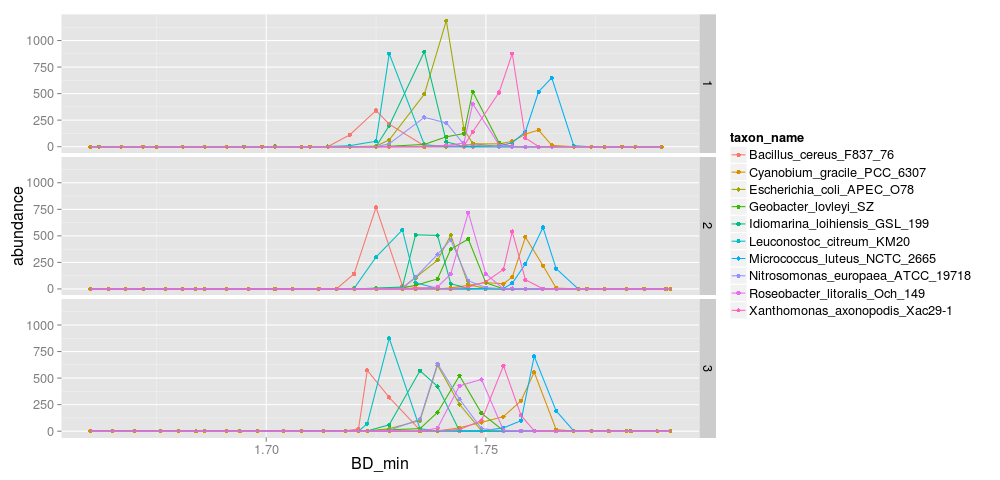

In [314]:
%%R -w 1000

ggplot(tbl.m, aes(BD_min, abundance, fill=taxon_name, group=taxon_name)) +
    #geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_point(aes(color=taxon_name)) +
    geom_line(aes(color=taxon_name)) +
    facet_grid(lib ~ .) +
    theme( text = element_text(size=16) )

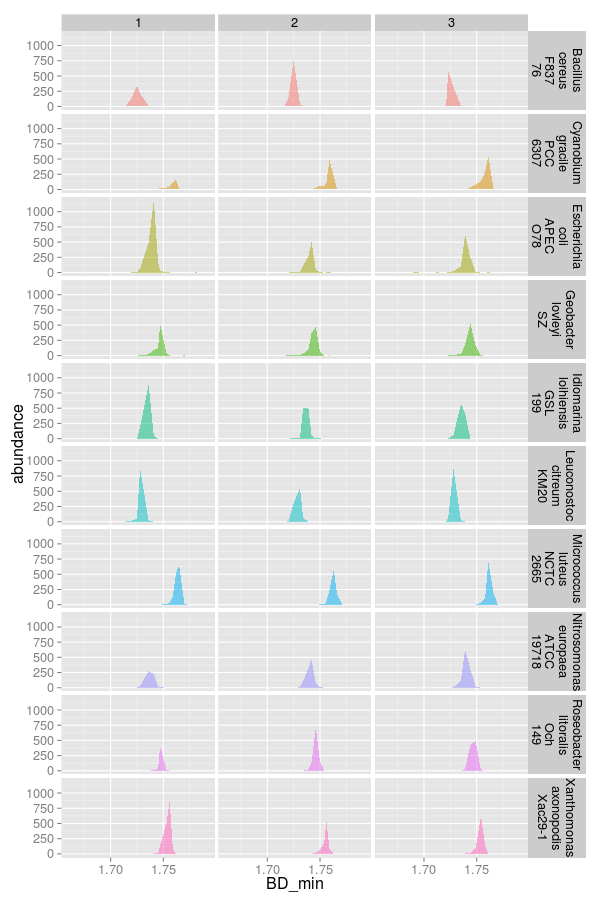

In [315]:
%%R -w 600 -h 900

tbl.m2 = tbl.m
tbl.m2$taxon_name = gsub("_","\n", tbl.m2$taxon_name)

ggplot(tbl.m2, aes(BD_min, abundance, fill=taxon_name, group=taxon_name)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    facet_grid(taxon_name ~ lib) +
    theme( text = element_text(size=16),
           legend.position = 'None'
        )

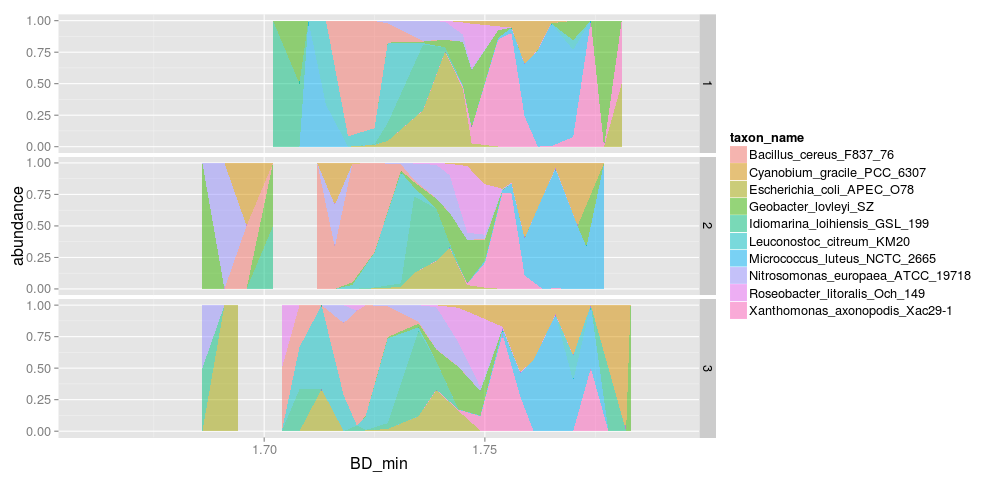

In [ ]:
%%R -w 1000

ggplot(tbl.m, aes(BD_min, abundance, fill=taxon_name, group=taxon_name)) +
    geom_area(stat='identity', alpha=0.5, position='fill') +
    facet_grid(lib ~ .) +
    theme( text = element_text(size=16) )

***
***
***

***
***
***

# Sandbox

## Grinder testing

* required options:
  * -rf
    * edit to use individual genome fasta files?

 
* individual fasta file input:
  * need to edit database
  * 2950sub database_create
  * 1800sub community_read_abundances
  * 1471  $self->{c_structs} = $self->community_structures

## Distributions in python

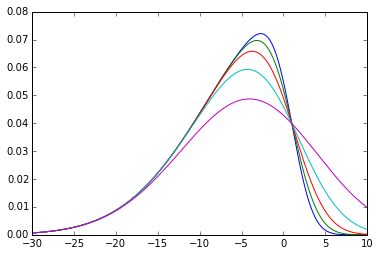

In [241]:
from scipy import linspace
from scipy import pi,sqrt,exp
from scipy.special import erf

from pylab import plot,show

def pdf(x):
    return 1/sqrt(2*pi) * exp(-x**2/2)

def cdf(x):
    return (1 + erf(x/sqrt(2))) / 2

def skew(x,e=0,w=1,a=0):
    t = (x-e) / w
    return 2 / w * pdf(t) * cdf(a*t)
    # You can of course use the scipy.stats.norm versions
    # return 2 * norm.pdf(t) * norm.cdf(a*t)


n = 2**10

e = 1.0 # location
w = 10.0 # scale

x = linspace(-30,10,n) 

for a in range(-5,0):
    p = skew(x,e,w,a)
    plot(x,p)

show()

In [253]:
import scipy.stats as ss

In [259]:
print ss.norm.stats(moments='mvsk')

(array(0.0), array(1.0), array(0.0), array(0.0))


In [144]:
import scipy
a, b = 0.1, 2.0
tn = scipy.stats.truncnorm(a,b)

In [164]:
from ggplot import *
import pandas as pd

In [263]:
import pymc

In [274]:
help(pymc.distributions.rskew_normal)

Help on function rskew_normal in module pymc.distributions:

rskew_normal(mu, tau, alpha, size=())
    Skew-normal random variates.



In [304]:
df = pd.DataFrame(pymc.distributions.rskew_normal(11000,10000,-100,size=10000)**10, columns=['x'])

In [328]:
import math

In [358]:
df = pd.DataFrame(pymc.distributions.rnormal(math.log(10),math.log(10),size=10000)**2, columns=['x'])

In [369]:
df = pd.DataFrame(np.random.triangular(-3,7,8,10000), columns=['x'])

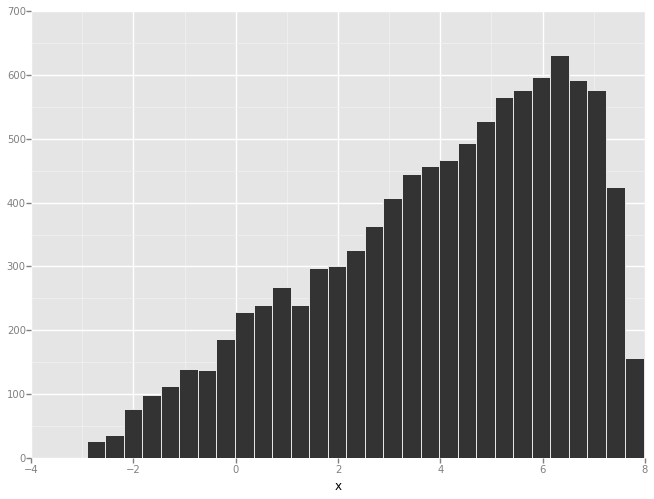

<ggplot: (8737283685749)>

In [370]:
ggplot(aes(x='x'), data=df) + \
    geom_histogram()

## skewed normal dist

In [250]:
import scipy.stats as ss
class skew_norm_gen(ss.rv_continuous):
    def pdf(self, x, s):
        return 2 * ss.norm.pdf(x) * ss.norm.cdf(x * s)
skew_norm = skew_norm_gen(name='skew_norm', shapes='s')

skew_norm.pdf(np.array([1,2,3]), 4)

array([ 0.48392612,  0.10798193,  0.0088637 ])

In [117]:
a = set([1,2,3])
b = set([2])

a - b

{1, 3}

In [125]:
print tree.all_intervals

set([Interval(1, 10, ['a', 10]), Interval(3, 6, ['c', 4]), Interval(4, 7, ['c', 4]), Interval(3, 6, ['b', 4])])


In [46]:
from intervaltree import Interval, IntervalTree

In [47]:
tree = IntervalTree()

In [126]:
tree.addi(1,10, ['a',10])
tree.addi(3,6, ['b',4])
tree.addi(3,6, ['c',4])

print tree.all_intervals

set([Interval(1, 10, ['a', 10]), Interval(3, 6, ['c', 4]), Interval(4, 7, ['c', 4]), Interval(3, 6, ['b', 4])])


In [49]:
tree.print_structure()

Node<3, balance=1>
||||:
 Interval(1, 10, ['a', 10])
 Interval(3, 6, ['b', 4])
>>>>:Node<4, balance=0>
    ||||:
     Interval(4, 7, ['c', 4])



In [108]:
def calcPercOverlap(iv1, iv2):
    if not iv1.overlaps(iv2):
        return 0.0
        
    tmpTree = IntervalTree()
    tmpTree.addi(iv1.begin, iv1.end, iv1.data)
    tmpTree.addi(iv2.begin, iv2.end, iv2.data)

    tmpTree.split_overlaps()
    
    if len(tmpTree) == 1:
        return 100.0
    
    for iv in tmpTree.iter():
        overlaps = tmpTree.search(iv.begin, iv.end)
        if len(overlaps) == 2:
            ivo = overlaps.pop()
            return float(ivo.end - ivo.begin) / ivo.data[1] * 100        
        elif len(overlaps) > 2:
            raise ValueError()
            

In [109]:
for iv in tree.iter():
    overlaps = tree.search(iv.begin, iv.end)
    for iv2 in overlaps:
        print calcPercOverlap(iv1, iv2)
    

100.0
75.0
30.0
30.0
75.0
100.0
30.0
75.0
100.0


In [50]:
iv1 = [x for x in tree.all_intervals][0]
iv2 = [x for x in tree.all_intervals][1]

In [72]:
tmpTree = IntervalTree()
tmpTree.addi(iv1.begin, iv1.end, iv1.data)
tmpTree.addi(iv2.begin, iv2.end, iv2.data)

tmpTree.split_overlaps()

for iv in tmpTree.iter():
    overlaps = tmpTree.search(iv.begin, iv.end)
    if len(overlaps) == 2:
        ivo = overlaps.pop()
        print float(ivo.end - ivo.begin) / ivo.data[1]        
    elif len(overlaps) > 2:
        raise ValueError()

0.75
0.75


In [70]:
[[x.begin,x.end,x.data] for x in overlaps]

[[4, 7, ['c', 4]], [4, 7, ['a', 10]]]

In [73]:
import itertools

In [77]:
for x in itertools.product(range(3), range(3)):
    print x

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


In [79]:
def calcPercOverlap(iv1, iv2):
    tmpTree = IntervalTree()
    tmpTree.addi(iv1.begin, iv1.end, iv1.data)
    tmpTree.addi(iv2.begin, iv2.end, iv2.data)

    tmpTree.split_overlaps()
    if

    for iv in tmpTree.iter():
        overlaps = tmpTree.search(iv.begin, iv.end)
        if len(overlaps) == 2:
            ivo = overlaps.pop()
            print float(ivo.end - ivo.begin) / ivo.data[1]        
        elif len(overlaps) > 2:
            raise ValueError()

In [87]:
for ints in itertools.product(tree.all_intervals, tree.all_intervals):
    print '---'
    if ints[0].overlaps(ints[1]):
        #tmpTree = IntervalTree()
        #tmpTree.addi(ints[0].begin, ints[0].end, ints[0].data)
        #tmpTree.addi(ints[1].begin, ints[1].end, ints[1].data)        
        #print float(ivo.end - ivo.begin) / ivo.data[1]   
        calcPercOverlap(ints[0], ints[1])
    else:
        pass
#    elif len(overlaps) > 2:
#        raise ValueError()
#    else: 

---
---
0.75
0.75
---
0.3
0.3
---
0.75
0.75
---
---
0.5
0.5
---
0.75
0.75
---
0.5
0.5
---


In [90]:
for ints in itertools.product(tree.all_intervals, tree.all_intervals):
    print sorted(ints, key=lambda x: x.data[1])[0]

Interval(1, 10, ['a', 10])
Interval(4, 7, ['c', 4])
Interval(3, 6, ['b', 4])
Interval(4, 7, ['c', 4])
Interval(4, 7, ['c', 4])
Interval(4, 7, ['c', 4])
Interval(3, 6, ['b', 4])
Interval(3, 6, ['b', 4])
Interval(3, 6, ['b', 4])
